In [ ]:
import requests
import pandas as pd
from datetime import datetime, timedelta
import time
import os

# ==========================================
# 1. CONFIGURATION
# ==========================================
HA_URL = "http://homeassistant.local:8123"
TOKEN = "YOUR_TOKEN"

# Define your period here
START_DATE = "2025-02-10"
END_DATE = "2025-12-28" 

# File names for storage
HOURLY_CSV = "quatt_hourly.csv"
DAILY_CSV = "quatt_daily.csv"

# ==========================================
# 2. HELPER FUNCTIONS
# ==========================================
def get_quatt_data(date_str):
    url = f"{HA_URL}/api/services/quatt/get_insights?return_response=true"
    headers = {
        "Authorization": f"Bearer {TOKEN}",
        "content-type": "application/json",
    }
    payload = {
        "from_date": date_str,
        "timeframe": "day",
        "advanced_insights": True
    }
    response = requests.post(url, headers=headers, json=payload)
    response.raise_for_status()
    return response.json()

# ==========================================
# 3. LOAD HISTORY & DETERMINE MISSING DATES
# ==========================================
print("--- Checking for existing history ---")

# Load Daily History
if os.path.exists(DAILY_CSV):
    df_daily_history = pd.read_csv(DAILY_CSV)
    # Ensure date is datetime and set as index
    df_daily_history['date'] = pd.to_datetime(df_daily_history['date'])
    df_daily_history = df_daily_history.set_index('date')
    existing_dates = set(df_daily_history.index.date)
    print(f"Loaded {len(df_daily_history)} daily records from {DAILY_CSV}.")
else:
    df_daily_history = pd.DataFrame()
    existing_dates = set()
    print("No existing daily history found.")

# Load Hourly History
if os.path.exists(HOURLY_CSV):
    df_hourly_history = pd.read_csv(HOURLY_CSV)
    # Ensure timestamp is datetime and set as index
    df_hourly_history['timestamp'] = pd.to_datetime(df_hourly_history['timestamp'])
    df_hourly_history = df_hourly_history.set_index('timestamp')
    print(f"Loaded {len(df_hourly_history)} hourly records from {HOURLY_CSV}.")
else:
    df_hourly_history = pd.DataFrame()

# Calculate dates to fetch
start_dt = datetime.strptime(START_DATE, "%Y-%m-%d")
end_dt = datetime.strptime(END_DATE, "%Y-%m-%d")
all_dates = pd.date_range(start=start_dt, end=end_dt)

# Filter out dates that already exist in the CSV
dates_to_fetch = [d for d in all_dates if d.date() not in existing_dates]

print(f"\nRequested range: {START_DATE} to {END_DATE} ({len(all_dates)} days)")
print(f"Already have:    {len(existing_dates)} days")
print(f"Need to fetch:   {len(dates_to_fetch)} days")

# ==========================================
# 4. MAIN EXECUTION LOOP (Only for new dates)
# ==========================================
hourly_chunks_new = []
daily_records_new = []

if dates_to_fetch:
    print("\n--- Starting data collection for missing dates ---")
    
    for current_date in dates_to_fetch:
        date_str = current_date.strftime("%Y-%m-%d")
        print(f"Fetching data for: {date_str}...", end=" ")
        
        try:
            # 1. Call API
            json_response = get_quatt_data(date_str)
            
            # 2. Validate Response Structure
            if not json_response or 'service_response' not in json_response:
                raise ValueError("Missing 'service_response' in API output")
                
            data = json_response['service_response']
            
            # 3. Prepare the base daily record
            daily_record = {
                "date": current_date, 
                "totalHpHeat": data.get("totalHpHeat", 0), 
                "totalHpElectric": data.get("totalHpElectric", 0),
                "totalBoilerHeat": data.get("totalBoilerHeat", 0),
                "totalBoilerGas": data.get("totalBoilerGas", 0),
                "averageCOP": data.get("averageCOP"),
                "savingsMoney": data.get("savingsMoney"),
                "savingsCo2": data.get("savingsCo2"),
                "savingsGas": data.get("savingsGas"),
                "savingsGasMoney": data.get("savingsGasMoney"),
                "savingsQuattElectricityCost": data.get("savingsQuattElectricityCost"),
                "co2GasSaved": data.get("co2GasSaved"),
                "co2Electricity": data.get("co2Electricity"),
                "hasTarrifs": data.get("hasTarrifs"),
                "status": "ok" # Mark as valid
            }

            # 4. Process Hourly Data
            df_main = pd.DataFrame(data.get('graph', []))
            df_out = pd.DataFrame(data.get('outsideTemperatureGraph', []))
            df_water = pd.DataFrame(data.get('waterTemperatureGraph', []))
            df_room = pd.DataFrame(data.get('roomTemperatureGraph', []))

            if not df_main.empty:
                # Merge hourly data
                # Note: This is where your 'timestamp' error likely occurs if data is malformed
                df_merged = df_main.merge(df_out, on='timestamp', how='outer')
                df_merged = df_merged.merge(df_water, on='timestamp', how='outer')
                df_merged = df_merged.merge(df_room, on='timestamp', how='outer')
                
                # Calculate averages inside the loop
                cols_to_avg = ['temperatureOutside', 'waterTemperature', 'roomTemperature', 'roomSetpoint']
                existing_cols = [c for c in cols_to_avg if c in df_merged.columns]
                
                if existing_cols:
                    averages = df_merged[existing_cols].mean().to_dict()
                    for key, value in averages.items():
                        daily_record[f"avg_{key}"] = value

                hourly_chunks_new.append(df_merged)
                print("Success.")
            else:
                print("Daily stats found, but no hourly graph data.")
            
            # Append the successfully processed record
            daily_records_new.append(daily_record)

        except Exception as e:
            print(f"SKIPPED (Saving empty record). Error: {e}")
            
            # This ensures the date is present in the CSV so it isn't requested again.
            failed_record = {
                "date": current_date,
                "totalHpHeat": 0,
                "totalHpElectric": 0,
                "totalBoilerHeat": 0,
                "totalBoilerGas": 0,
                "status": "missing_data" # Flag to identify these rows later
            }
            daily_records_new.append(failed_record)
        
        time.sleep(5) 
else:
    print("\nNo new dates to fetch.")

# ==========================================
# 5. MERGE & SAVE
# ==========================================
print("\n--- Processing and Saving ---")

# --- PROCESS HOURLY ---
df_hourly_new = pd.DataFrame()
if hourly_chunks_new:
    df_hourly_new = pd.concat(hourly_chunks_new, ignore_index=True)
    # Check if timestamp exists before processing (in case a chunk was bad)
    if 'timestamp' in df_hourly_new.columns:
        df_hourly_new['timestamp'] = pd.to_datetime(df_hourly_new['timestamp'])
        df_hourly_new = df_hourly_new.set_index('timestamp')

# Combine History + New
if not df_hourly_new.empty:
    df_hourly = pd.concat([df_hourly_history, df_hourly_new])
else:
    df_hourly = df_hourly_history

# Remove duplicates just in case (keep last) and sort
if not df_hourly.empty:
    df_hourly = df_hourly[~df_hourly.index.duplicated(keep='last')].sort_index()
    # Save to CSV
    df_hourly.to_csv(HOURLY_CSV)
    print(f"Saved updated hourly data to {HOURLY_CSV}")

# --- PROCESS DAILY ---
df_daily_new = pd.DataFrame()
if daily_records_new:
    df_daily_new = pd.DataFrame(daily_records_new)
    df_daily_new['date'] = pd.to_datetime(df_daily_new['date'])
    df_daily_new = df_daily_new.set_index('date')

# Combine History + New
if not df_daily_new.empty:
    df_daily = pd.concat([df_daily_history, df_daily_new])
else:
    df_daily = df_daily_history

# Remove duplicates, sort, and recalculate derived columns
if not df_daily.empty:
    df_daily = df_daily[~df_daily.index.duplicated(keep='last')].sort_index()
    
    # Recalculate totalHeatPerHour (handle NaNs safely with fillna)
    df_daily['totalHeatPerHour'] = (
        df_daily.get('totalHpHeat', 0).fillna(0) + df_daily.get('totalBoilerHeat', 0).fillna(0)
    ) / 24
    
    # Save to CSV
    df_daily.to_csv(DAILY_CSV)
    print(f"Saved updated daily data to {DAILY_CSV}")

print("\nComplete!")
print(f"Total Hourly Rows: {len(df_hourly)}")
print(f"Total Daily Rows:  {len(df_daily)}")

--- Checking for existing history ---
Loaded 322 daily records from quatt_daily.csv.
Loaded 4898 hourly records from quatt_hourly.csv.

Requested range: 2025-02-10 to 2025-12-28 (322 days)
Already have:    322 days
Need to fetch:   0 days

No new dates to fetch.

--- Processing and Saving ---
Saved updated hourly data to quatt_hourly.csv
Saved updated daily data to quatt_daily.csv

Complete!
Total Hourly Rows: 4898
Total Daily Rows:  322


PART 1: LOCAL DATA ANALYSIS (df_hourly)
Data points after filter: 110
Points removed as outliers: 8


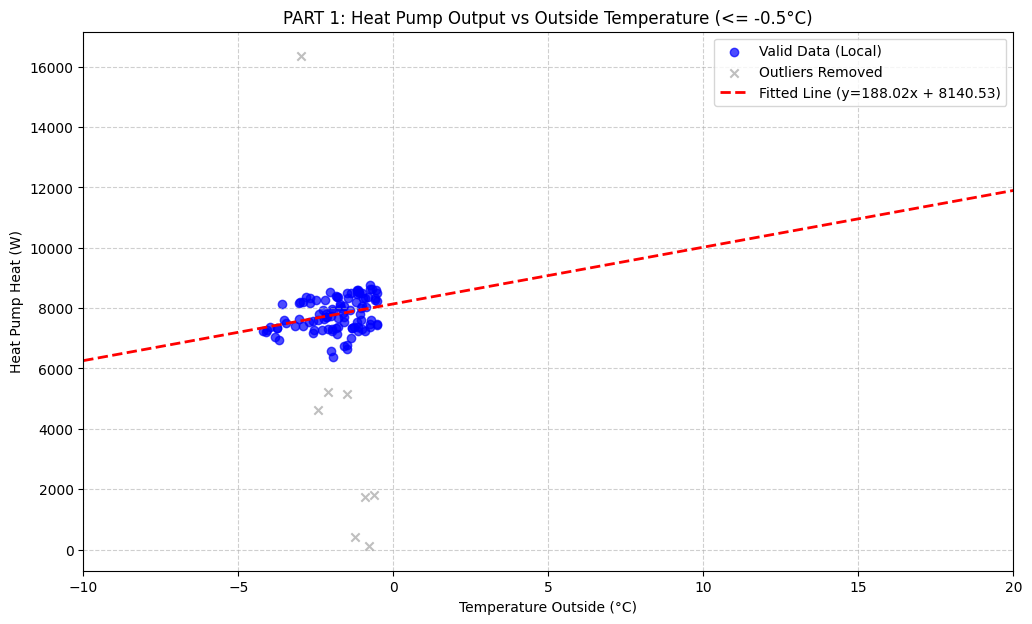

Part 1 Equation: y = 188.02x + 8140.53

PART 2: API DATA ANALYSIS (Dynamic Max Power Filter)
Fetching raw history from 2025-12-19 17:11:16.557860 to 2025-12-29 17:11:16.557860...
Splitting raw JSON into separate lists...
Processing Temperature (27141 records)...
Processing Power (58090 records)...

Joining DataFrames...
Merged Data Points: 8869
----------------------------------------
DYNAMIC FILTER CALCULATED:
Max Wattage Found: 9612 W
At Temperature:    0.92 °C
-> Setting MIN_TEMP_FILTER to 0.92 °C
----------------------------------------
Points after Dynamic Filter: 5225
Points after Neighbor Filter: 2556
Points after Outlier (Z-Score) Filter: 2425


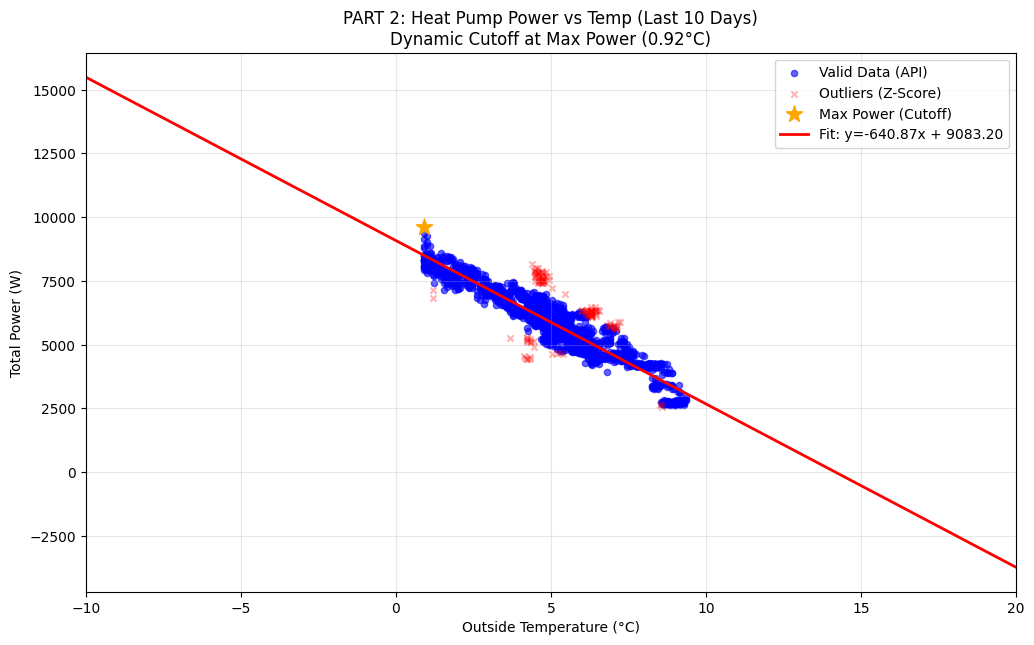

Part 2 Equation: Power = -640.87 * Temp + 9083.20


In [2]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import gc

# ==============================================================================
# PART 1: LOCAL DATAFRAME ANALYSIS (df_hourly)
# ==============================================================================
print("="*60)
print("PART 1: LOCAL DATA ANALYSIS (df_hourly)")
print("="*60)


if 'df_hourly' in locals() and not df_hourly.empty:
    # 1. FILTER
    # Apply the specific filter: Heat >= 0 AND Temp <= -0.5
    df_filtered = df_hourly[
        (df_hourly['hpHeat'] >= 0) & 
        (df_hourly['temperatureOutside'] <= -0.5) &
        (df_hourly['temperatureOutside'].notna())
    ].copy()

    print(f"Data points after filter: {len(df_filtered)}")

    if len(df_filtered) > 2:
        # 2. OUTLIER DETECTION (Residual Z-Score)
        x_temp = df_filtered['temperatureOutside']
        y_temp = df_filtered['hpHeat']
        
        # Fit temporary line
        slope_temp, intercept_temp = np.polyfit(x_temp, y_temp, 1)
        
        # Calculate Residuals
        residuals = y_temp - (slope_temp * x_temp + intercept_temp)
        std_dev = np.std(residuals)
        
        # Filter: Keep points within 1 Standard Deviation
        if std_dev > 0:
            mask_clean = np.abs(residuals) < (1 * std_dev)
            df_clean = df_filtered[mask_clean].copy()
        else:
            df_clean = df_filtered.copy()
            
        print(f"Points removed as outliers: {len(df_filtered) - len(df_clean)}")

        # 3. FINAL FITTING
        x = df_clean['temperatureOutside']
        y = df_clean['hpHeat']
        
        if len(x) > 1:
            slope_local, intercept_local = np.polyfit(x, y, 1)
            
            # 4. EXTRAPOLATION
            x_line = np.linspace(-10, 20, 100)
            y_line = slope_local * x_line + intercept_local

            # 5. PLOTTING
            plt.figure(figsize=(12, 7))
            plt.scatter(x, y, color='blue', alpha=0.7, label='Valid Data (Local)')

            # Plot Outliers
            df_outliers = df_filtered[~df_filtered.index.isin(df_clean.index)]
            if not df_outliers.empty:
                plt.scatter(df_outliers['temperatureOutside'], df_outliers['hpHeat'], 
                            color='gray', marker='x', alpha=0.5, label='Outliers Removed')

            plt.plot(x_line, y_line, color='red', linewidth=2, linestyle='--', 
                     label=f'Fitted Line (y={slope_local:.2f}x + {intercept_local:.2f})')

            plt.title('PART 1: Heat Pump Output vs Outside Temperature (<= -0.5°C)')
            plt.xlabel('Temperature Outside (°C)')
            plt.ylabel('Heat Pump Heat (W)')
            plt.xlim(-10, 20)
            plt.grid(True, linestyle='--', alpha=0.6)
            plt.legend()
            plt.show()
            
            print(f"Part 1 Equation: y = {slope_local:.2f}x + {intercept_local:.2f}")
        else:
            print("Part 1: Not enough clean data points to fit a line.")
    else:
        print("Part 1: Not enough data points after filtering.")
else:
    print("Part 1 Skipped: 'df_hourly' not found or empty.")


# ==============================================================================
# PART 2: HOME ASSISTANT API ANALYSIS (Dynamic Filter)
# ==============================================================================
print("\n" + "="*60)
print("PART 2: API DATA ANALYSIS (Dynamic Max Power Filter)")
print("="*60)

# 1. CONFIGURATION

ENTITY_TEMP = "sensor.heatpump_hp1_temperature_outside"
ENTITY_POWER = "sensor.heatpump_total_power"

DAYS_HISTORY = 10
MIN_POWER_FILTER = 2500 #Needs to be above 2kW minimum output
STD_DEV_THRESHOLD = 2.0 

# 2. FETCH RAW DATA
def get_raw_history():
    end_dt = datetime.now()
    start_dt = end_dt - timedelta(days=DAYS_HISTORY)
    
    url = f"{HA_URL}/api/history/period/{start_dt.isoformat()}"
    headers = {
        "Authorization": f"Bearer {TOKEN}",
        "content-type": "application/json",
    }
    params = {
        "end_time": end_dt.isoformat(),
        "filter_entity_id": f"{ENTITY_TEMP},{ENTITY_POWER}",
        "minimal_response": "false",
        "significant_changes_only": "0"
    }
    
    print(f"Fetching raw history from {start_dt} to {end_dt}...")
    try:
        response = requests.get(url, headers=headers, params=params)
        response.raise_for_status()
        return response.json()
    except Exception as e:
        print(f"API Error: {e}")
        return []

# 3. SPLIT & CALCULATE MEDIAN
raw_json = get_raw_history()
df_temp_median = None
df_power_median = None

if raw_json:
    raw_temp_list = []
    raw_power_list = []
    
    print("Splitting raw JSON into separate lists...")
    for entity_list in raw_json:
        if not entity_list: continue
        e_id = entity_list[0]['entity_id']
        if e_id == ENTITY_TEMP: raw_temp_list = entity_list
        elif e_id == ENTITY_POWER: raw_power_list = entity_list
            
    del raw_json
    gc.collect()

    # Process Temp
    if raw_temp_list:
        print(f"Processing Temperature ({len(raw_temp_list)} records)...")
        df_t = pd.DataFrame(raw_temp_list)
        df_t = df_t[['last_changed', 'state']]
        df_t['timestamp'] = pd.to_datetime(df_t['last_changed'], utc=True).dt.tz_convert(None).dt.floor('min')
        df_t['state'] = pd.to_numeric(df_t['state'], errors='coerce')
        df_t = df_t.dropna(subset=['state'])
        df_temp_median = df_t.groupby('timestamp')['state'].median().rename('temp')
        del df_t, raw_temp_list
        gc.collect()

    # Process Power
    if raw_power_list:
        print(f"Processing Power ({len(raw_power_list)} records)...")
        df_p = pd.DataFrame(raw_power_list)
        df_p = df_p[['last_changed', 'state']]
        df_p['timestamp'] = pd.to_datetime(df_p['last_changed'], utc=True).dt.tz_convert(None).dt.floor('min')
        df_p['state'] = pd.to_numeric(df_p['state'], errors='coerce')
        df_p = df_p.dropna(subset=['state'])
        df_power_median = df_p.groupby('timestamp')['state'].median().rename('power')
        del df_p, raw_power_list
        gc.collect()
else:
    print("No data returned from API.")

# 4. JOIN & FILTER PIPELINE
if df_temp_median is not None and df_power_median is not None:
    print("\nJoining DataFrames...")
    
    # Join
    df_merged = pd.merge(df_temp_median, df_power_median, left_index=True, right_index=True, how='left')
    df_merged = df_merged.dropna(subset=['power'])
    print(f"Merged Data Points: {len(df_merged)}")
    
    # Filter: Power Threshold ONLY
    df_power_valid = df_merged[df_merged['power'] >= MIN_POWER_FILTER].copy()
    
    if not df_power_valid.empty:
        # DYNAMIC FILTER CALCULATION
        max_power_idx = df_power_valid['power'].idxmax()
        max_power_val = df_power_valid.loc[max_power_idx, 'power']
        dynamic_min_temp = df_power_valid.loc[max_power_idx, 'temp']
        
        print("-" * 40)
        print(f"DYNAMIC FILTER CALCULATED:")
        print(f"Max Wattage Found: {max_power_val:.0f} W")
        print(f"At Temperature:    {dynamic_min_temp:.2f} °C")
        print(f"-> Setting MIN_TEMP_FILTER to {dynamic_min_temp:.2f} °C")
        print("-" * 40)
        
        # Apply Dynamic Temp Filter
        df_basic = df_power_valid[df_power_valid['temp'] >= dynamic_min_temp].copy()
        print(f"Points after Dynamic Filter: {len(df_basic)}")
        
        if len(df_basic) > 10:
            # Neighbor Deviation (±5%)
            df_sorted = df_basic.sort_values(by='temp').copy()
            df_sorted['next_power'] = df_sorted['power'].shift(-1)
            df_sorted['pct_diff'] = (df_sorted['next_power'] - df_sorted['power']) / df_sorted['power']
            
            mask_stable = (df_sorted['pct_diff'] >= -0.05) & (df_sorted['pct_diff'] <= 0.05)
            df_neighbor_clean = df_sorted[mask_stable].copy()
            
            print(f"Points after Neighbor Filter: {len(df_neighbor_clean)}")
            
            if len(df_neighbor_clean) > 5:
                # Statistical Outlier Detection (Z-Score)
                x_temp = df_neighbor_clean['temp']
                y_temp = df_neighbor_clean['power']
                slope_api, intercept_api = np.polyfit(x_temp, y_temp, 1)
                
                residuals = y_temp - (slope_api * x_temp + intercept_api)
                std_dev = np.std(residuals)
                
                mask_outlier = np.abs(residuals) < (STD_DEV_THRESHOLD * std_dev)
                df_final = df_neighbor_clean[mask_outlier].copy()
                
                print(f"Points after Outlier (Z-Score) Filter: {len(df_final)}")
                
                # PLOT
                if len(df_final) > 1:
                    x = df_final['temp']
                    y = df_final['power']
                    slope_api, intercept_api = np.polyfit(x, y, 1)
                    
                    x_line = np.linspace(-10, 20, 100)
                    y_line_calculated = slope_api * x_line + intercept_api

                    plt.figure(figsize=(12, 7))
                    
                    # Plot Final Data
                    plt.scatter(x, y, alpha=0.6, s=20, c='blue', label='Valid Data (API)')
                    
                    # Plot Outliers
                    df_removed_z = df_neighbor_clean[~mask_outlier]
                    if not df_removed_z.empty:
                        plt.scatter(df_removed_z['temp'], df_removed_z['power'], alpha=0.3, s=20, c='red', marker='x', label='Outliers (Z-Score)')

                    # Plot Max Power Point
                    plt.scatter([dynamic_min_temp], [max_power_val], color='orange', s=150, marker='*', zorder=5, label='Max Power (Cutoff)')

                    plt.plot(x_line, y_line_calculated, color='red', linewidth=2, label=f'Fit: y={slope_api:.2f}x + {intercept_api:.2f}')
                    
                    plt.title(f'PART 2: Heat Pump Power vs Temp (Last {DAYS_HISTORY} Days)\nDynamic Cutoff at Max Power ({dynamic_min_temp:.2f}°C)')
                    plt.xlabel('Outside Temperature (°C)')
                    plt.ylabel('Total Power (W)')
                    plt.xlim(-10, 20)
                    plt.legend()
                    plt.grid(True, alpha=0.3)
                    plt.show()
                    
                    print(f"Part 2 Equation: Power = {slope_api:.2f} * Temp + {intercept_api:.2f}")
                else:
                    print("Part 2: Not enough data after Z-Score filter.")
            else:
                print("Part 2: Not enough data after Neighbor filter.")
        else:
            print("Part 2: Not enough data after Dynamic Temp filter.")
    else:
        print("Part 2: No data found above MIN_POWER_FILTER.")
else:
    print("Part 2: Failed to process: One or both sensors missing data.")

INTERSECTION POINTS
3. Freezing Performance Limit:   -3.47 °C
3. Freezing Performance Limit with backup:   -6.99 °C
4. Temp at which CiC asks full capacity (est. stooklijn vs est. actual perf): 1.14 °C
   (At this temp, system delivers 8354 W)


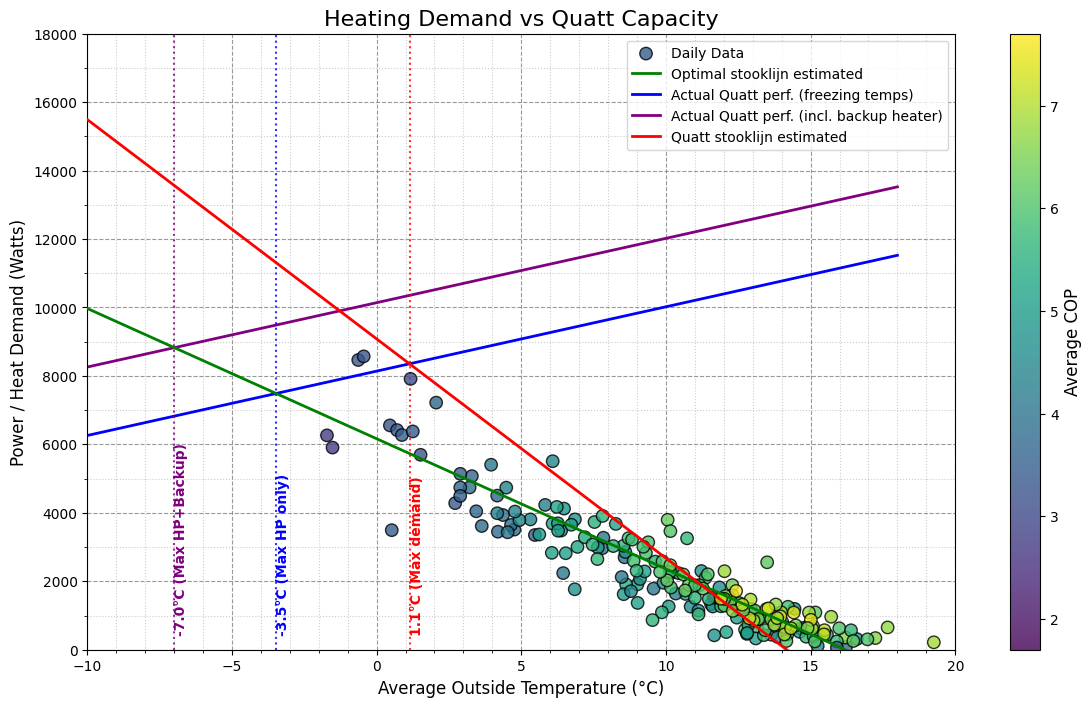

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
from scipy.stats import linregress

# ==========================================
# 0. PLOT CONFIGURATION
# ==========================================
show_quatt_specs = False  # Set to True to show Quatt v1.5 DUO Nominal/Max lines

# Check if dataframe exists
if 'df_daily' in locals() and not df_daily.empty:
    
    # 1. PREPARE REAL DATA
    plot_data = df_daily[['avg_temperatureOutside', 'totalHeatPerHour', 'averageCOP']].copy()
    plot_data = plot_data.replace([np.inf, -np.inf], np.nan).dropna()

    if len(plot_data) >= 2:
        
        x = plot_data['avg_temperatureOutside']
        y = plot_data['totalHeatPerHour']
        colors = plot_data['averageCOP']
        
        # --- HOME HYBRID FIT (Usage) ---
        z_global = np.polyfit(x, y, 1)
        slope_global = z_global[0]
        intercept_global = z_global[1]
        
        # Calculate the fixed X-intercept (Temperature where heating is 0)
        if slope_global != 0:
            x_intercept_fixed = -intercept_global / slope_global
        else:
            x_intercept_fixed = 20 
            
        mask = (x >= -5) & (x <= 5)
        x_subset = x[mask]
        y_subset = y[mask]
        
        if len(x_subset) > 0:
            x_shifted = x_subset - x_intercept_fixed
            slope_special = np.dot(x_shifted, y_subset) / np.dot(x_shifted, x_shifted)
            intercept_special = -slope_special * x_intercept_fixed
            
            def special_trendline(val):
                return slope_special * (val - x_intercept_fixed)
        else:
            slope_special = slope_global
            intercept_special = intercept_global
            def special_trendline(val):
                return (slope_global * val) + intercept_global

        # --- QUATT REFERENCE DATA ---
        temps_ref = np.array([7, 2, -7])
        p_nom_duo_W = np.array([9.0, 7.4, 5.4]) * 1000
        p_max_duo_W = np.array([12.0, 10.4, 7.6]) * 1000

        slope_nom, intercept_nom, _, _, _ = linregress(temps_ref, p_nom_duo_W)
        slope_max, intercept_max, _, _, _ = linregress(temps_ref, p_max_duo_W)

        # ---------------------------------------------------------
        # ACTUAL QUATT PERF (FREEZING TEMPS) - FROM PART 1
        # ---------------------------------------------------------     
        if 'slope_local' in locals() and 'intercept_local' in locals():
            slope_freeze = slope_local
            intercept_freeze = intercept_local
            label_freeze = f"Actual Quatt perf. (freezing temps)"
        
        if 'slope_local' in locals() and 'intercept_local' in locals():
            slope_freeze_backup_heater = slope_local
            intercept_freeze_backup_heater = intercept_local+2000
            label_freeze_backup = f"Actual Quatt perf. (incl. backup heater)"

        # ==========================================
        # CALCULATE INTERSECTIONS
        # ==========================================
        
        # 1. Intersection with Nominal
        denom_nom = slope_special - slope_nom
        if denom_nom != 0:
            x_cross_nom = (intercept_nom - intercept_special) / denom_nom
        else:
            x_cross_nom = None

        # 2. Intersection with Max
        denom_max = slope_special - slope_max
        if denom_max != 0:
            x_cross_max = (intercept_max - intercept_special) / denom_max
        else:
            x_cross_max = None

        # 3. Intersection with Freezing Performance (Using Part 1 Data)
        denom_freeze = slope_special - slope_freeze
        if denom_freeze != 0:
            x_cross_freeze = (intercept_freeze - intercept_special) / denom_freeze
            y_cross_freeze = slope_special * x_cross_freeze + intercept_special
        else:
            x_cross_freeze = None

         # 4. Intersection with Freezing backup heater Performance (Using Part 1 Data)
        denom_freeze_backup = slope_special - slope_freeze_backup_heater
        if denom_freeze_backup != 0:
            x_cross_freeze_backup = (intercept_freeze_backup_heater - intercept_special) / denom_freeze_backup
            y_cross_backup = slope_special * x_cross_freeze_backup + intercept_special
        else:
            x_cross_freeze_backup = None

        # ==========================================
        # PLOTTING
        # ==========================================
        plt.figure(figsize=(14, 8))
        ax = plt.gca()
        
        # Scatter & Trendlines
        sc = plt.scatter(x, y, c=colors, cmap='viridis', s=80, alpha=0.8, edgecolors='black', zorder=3, label='Daily Data')
        cbar = plt.colorbar(sc)
        cbar.set_label('Average COP', fontsize=12)
        
        x_range = np.linspace(-12, 18, 100)
        
        # 1. Usage Line (Green Dashed)
        plt.plot(x_range, special_trendline(x_range), color='green', linestyle='-', linewidth=2, label='Optimal stooklijn estimated', zorder=4)

        # 2. Quatt Nominal/Max (CONDITIONAL)
        if show_quatt_specs:
            y_nom = slope_nom * x_range + intercept_nom
            y_max = slope_max * x_range + intercept_max
            plt.plot(x_range, y_nom, label='Quatt Nominal', color='cyan', linestyle='-.', alpha=0.8, zorder=2)
            plt.plot(x_range, y_max, label='Quatt Max', color='orange', linestyle='-.', alpha=0.8, zorder=2)

        # 3. Actual Quatt perf. (freezing temps) - FROM PART 1
        y_freeze = slope_freeze * x_range + intercept_freeze
        plt.plot(x_range, y_freeze, label=label_freeze, color='blue', linestyle='-', linewidth=2, alpha=1.0, zorder=2)

        # 4. Actual Quatt perf. backup heater (freezing temps) - FROM PART 1
        y_freeze_backup = slope_freeze_backup_heater * x_range + intercept_freeze_backup_heater
        plt.plot(x_range, y_freeze_backup, label=label_freeze_backup, color='Purple', linestyle='-', linewidth=2, alpha=1.0, zorder=2)

        # ---------------------------------------------------------
        # QUATT STOOKLIJN ESTIMATED - FROM PART 2
        # ---------------------------------------------------------
        x_cross_stook_freeze = None
        
        if 'slope_api' in locals() and 'intercept_api' in locals():
            # Calculate Y values
            y_line_stook = slope_api * x_range + intercept_api
            
            # Plot the line 
            plt.plot(x_range, y_line_stook, color='red', linestyle='-', linewidth=2, label=f'Quatt stooklijn estimated', zorder=5)
            
            # ---------------------------------------------------------
            # NEW INTERSECTION: Stooklijn vs Actual Perf (Green Dotted)
            # ---------------------------------------------------------
            denom_stook_freeze = slope_api - slope_freeze
            if denom_stook_freeze != 0:
                x_cross_stook_freeze = (intercept_freeze - intercept_api) / denom_stook_freeze
                y_cross_stook_freeze = slope_api * x_cross_stook_freeze + intercept_api
        
        # --- PLOT INTERSECTIONS (CONDITIONAL) ---
        
        if show_quatt_specs:
            # Nominal Intersection
            if x_cross_nom is not None:
                plt.axvline(x_cross_nom, color='cyan', linestyle=':', alpha=0.5)
                plt.text(x_cross_nom, 500, f"{x_cross_nom:.1f}°C (Max Nom)", color='cyan', fontweight='bold', ha='right', rotation=90)

            # Max Intersection
            if x_cross_max is not None:
                plt.axvline(x_cross_max, color='orange', linestyle=':', alpha=0.5)
                plt.text(x_cross_max, 500, f"{x_cross_max:.1f}°C (Max spec)", color='orange', fontweight='bold', ha='right', rotation=90)

        # Freezing Intersection (Always show this as it relates to Part 1 vs Usage)
        if x_cross_freeze is not None:
            plt.axvline(x_cross_freeze, color='blue', linestyle=':', alpha=0.8)
            plt.text(x_cross_freeze, 500, f"{x_cross_freeze:.1f}°C (Max HP only)", color='blue', fontweight='bold', ha='left', rotation=90)

        if x_cross_stook_freeze is not None:
            plt.axvline(x_cross_stook_freeze, color='red', linestyle=':', alpha=0.8)
            plt.text(x_cross_stook_freeze, 500, f"{x_cross_stook_freeze:.1f}°C (Max demand)", color='red', fontweight='bold', ha='left', rotation=90)

        # Freezing Intersection (Always show this as it relates to Part 1 vs Usage)
        if x_cross_freeze_backup is not None:
            plt.axvline(x_cross_freeze_backup, color='purple', linestyle=':', alpha=0.8)
            plt.text(x_cross_freeze_backup, 500, f"{x_cross_freeze_backup:.1f}°C (Max HP+Backup)", color='purple', fontweight='bold', ha='left', rotation=90)
            
        # Formatting
        plt.title('Heating Demand vs Quatt Capacity', fontsize=16)
        plt.xlabel('Average Outside Temperature (°C)', fontsize=12)
        plt.ylabel('Power / Heat Demand (Watts)', fontsize=12)
        
        ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_minor_locator(ticker.MultipleLocator(1000))
        plt.grid(True, which='major', linestyle='--', alpha=0.8, color='gray')
        plt.grid(True, which='minor', linestyle=':', alpha=0.4, color='gray')
        plt.xlim(left=-10, right=20)
        plt.ylim(bottom=0, top=18000)
        plt.legend(loc='upper right')

        # --- PRINT RESULTS ---
        print("=" * 60)
        print(f"INTERSECTION POINTS")
        print("=" * 60)
        
        if show_quatt_specs:
            if x_cross_nom:
                print(f"1. NOMINAL capacity reached at:  {x_cross_nom:.2f} °C")
            
            if x_cross_max:
                print(f"2. MAX spec capacity reached at:      {x_cross_max:.2f} °C")

        if x_cross_freeze:
            print(f"3. Freezing Performance Limit:   {x_cross_freeze:.2f} °C")
        if x_cross_freeze_backup:
            print(f"3. Freezing Performance Limit with backup:   {x_cross_freeze_backup:.2f} °C")
        if x_cross_stook_freeze:
            print(f"4. Temp at which CiC asks full capacity (est. stooklijn vs est. actual perf): {x_cross_stook_freeze:.2f} °C")
            print(f"   (At this temp, system delivers {y_cross_stook_freeze:.0f} W)")
            
        print("=" * 60)
        
        plt.show()
        
    else:
        print("Not enough valid data points to plot.")
else:
    print("Dataframe 'df_daily' not found.")